In [1]:
#Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
import nibabel as nib
import pandas as pd


## Funciones

In [5]:
import os
import numpy as np
import pydicom
from scipy.spatial.distance import pdist

def compute_tumor_volumes(ct_folder, seg_file, keyword_filter="Tumor"):
    """
    Calcula volúmenes y diámetros máximos (mm) de todos los segmentos (por ejemplo, Tumor_1, Tumor_2)
    incluso cuando seg_data no está separado por segmento.
    """

    # --- Leer CTs para obtener spacing ---
    ct_files = [
        pydicom.dcmread(os.path.join(ct_folder, f))
        for f in sorted(os.listdir(ct_folder))
        if f.endswith(".dcm")
    ]
    ct_files.sort(key=lambda x: float(x.ImagePositionPatient[2]))
    slice_thickness = float(ct_files[0].SliceThickness)
    pixel_spacing = [float(v) for v in ct_files[0].PixelSpacing]
    voxel_volume_mm3 = pixel_spacing[0] * pixel_spacing[1] * slice_thickness

    # --- Leer DICOM SEG ---
    seg_ds = pydicom.dcmread(seg_file)
    seg_data = seg_ds.pixel_array  # (n_slices, H, W)
    segment_seq = seg_ds.SegmentSequence
    per_frame_info = seg_ds.PerFrameFunctionalGroupsSequence

    # --- Crear máscaras por segmento ---
    segment_masks = {}
    for frame_idx, frame_info in enumerate(per_frame_info):
        seg_num = frame_info.SegmentIdentificationSequence[0].ReferencedSegmentNumber
        if seg_num not in segment_masks:
            segment_masks[seg_num] = []
        segment_masks[seg_num].append(seg_data[frame_idx])

    # Convertir listas a arrays (n_slices, H, W)
    for seg_num in segment_masks:
        segment_masks[seg_num] = np.stack(segment_masks[seg_num], axis=0)
    # --- Calcular volúmenes ---
    results = []
    for seg_num, mask in segment_masks.items():
        print(f"mask shape: {mask.shape}")
        seg_info = segment_seq[seg_num - 1]  # los segmentos se indexan desde 1
        label_name = seg_info.SegmentLabel
        print("processing segment:", seg_num, label_name)

        # Filtrar por palabra clave (tumor)
        if keyword_filter.lower() not in label_name.lower():
            continue

        # Calcular volumen
        tumor_voxels = np.sum(mask > 0)
        volume_mm3 = tumor_voxels * voxel_volume_mm3
        volume_ml = volume_mm3 / 1000.0

        # Calcular diámetro máximo
        max_diameter_mm = 0.0
        for slice_mask in mask:
            coords = np.argwhere(slice_mask > 0)
            if coords.shape[0] > 1:
                coords_mm = coords * pixel_spacing  # [y, x] * [dy, dx]
                dists = pdist(coords_mm)
                if len(dists) > 0:
                    max_diameter_mm = max(max_diameter_mm, np.max(dists))

        results.append({
            "segment_number": seg_num,
            "segment_label": label_name,
            "volume_mm3": volume_mm3,
            "volume_ml": volume_ml,
            "max_diameter_mm": max_diameter_mm
        })

    return results


In [6]:
ct_folder = "/home/data/Datasets/Colorectal-Liver-Metastases/CRLM-CT-1080/10-04-1994-NA-CT ANGIO LIVER WITH CHPEL-75931/101.000000-NA-99240/"
seg_file = "/home/data/Datasets/Colorectal-Liver-Metastases/CRLM-CT-1080/10-04-1994-NA-CT ANGIO LIVER WITH CHPEL-75931/100.000000-Segmentation-45666/1-1.dcm"

In [7]:
res1 = compute_tumor_volumes(ct_folder, seg_file, keyword_filter="Tumor")

mask shape: (128, 512, 512)
processing segment: 1 Liver
mask shape: (92, 512, 512)
processing segment: 2 Liver Remnant
mask shape: (69, 512, 512)
processing segment: 3 Hepatic
mask shape: (51, 512, 512)
processing segment: 4 Portal
mask shape: (92, 512, 512)
processing segment: 5 Tumor_1
mask shape: (14, 512, 512)
processing segment: 6 Tumor_2
mask shape: (14, 512, 512)
processing segment: 7 Tumor_3


In [8]:
res1

[{'segment_number': 5,
  'segment_label': 'Tumor_1',
  'volume_mm3': 475852.177734375,
  'volume_ml': 475.852177734375,
  'max_diameter_mm': 102.51998661846382},
 {'segment_number': 6,
  'segment_label': 'Tumor_2',
  'volume_mm3': 5959.560546875,
  'volume_ml': 5.959560546875,
  'max_diameter_mm': 21.2651600334914},
 {'segment_number': 7,
  'segment_label': 'Tumor_3',
  'volume_mm3': 5959.560546875,
  'volume_ml': 5.959560546875,
  'max_diameter_mm': 21.2651600334914}]

In [9]:
import pandas as pd

def save_tumor_volumes_to_csv_simple(results_dict, output_csv):
    """
    Guarda en CSV los volúmenes de tumores a partir de results_all
    donde results_all[p] es una lista de diccionarios de la forma:
    [{"segment_number":..., "segment_label":..., "volume_mm3":..., "volume_ml":...}, ...]
    
    output_csv: ruta del CSV de salida
    """
    rows = []
    for ct_id, res_list in results_dict.items():
        # Calcular volumen total por CT/paciente
        total_volume_ml = sum(r["volume_ml"] for r in res_list)
        for r in res_list:
            rows.append({
                "CT_ID": ct_id,
                "Tumor_ID": r["segment_number"],
                "Segment_Name": r["segment_label"],
                "Volume_mm3": r["volume_mm3"],
                "Volume_ml": r["volume_ml"],
                "Max_Diameter_mm": r["max_diameter_mm"],
                "Total_CT_Volume_ml": total_volume_ml
            })
    
    df = pd.DataFrame(rows)
    df.to_csv(output_csv, index=False)
    print(f"Resultados guardados en: {output_csv}")
    return df



## Colorectal

In [10]:
CRLM_path = "/home/data/Datasets/Colorectal-Liver-Metastases/"

In [11]:
patients = os.listdir(CRLM_path)
patients.sort()

In [12]:
results_all = {}
for p in patients:
    print(p)
    if not os.path.isdir(os.path.join(CRLM_path, p)):
        continue
    list_folders = os.listdir(os.path.join(CRLM_path, p))
    for f in list_folders:
        #print(f)
        list_folders2 = os.listdir(os.path.join(CRLM_path, p, f))
        for f2 in list_folders2:
            if "Segmentation" in f2:
                seg_path = os.path.join(CRLM_path, p, f, f2, "1-1.dcm")
            else:
                ct_path = os.path.join(CRLM_path, p, f, f2)
            
        try:
            res = compute_tumor_volumes(ct_path, seg_path, keyword_filter="Tumor")
            results_all[p] = res
            total_volume_ml = sum(r["volume_ml"] for r in res)
            print(f"{p}: {len(res)} tumores -> {total_volume_ml:.2f} mL")
        except Exception as e:
            print(f"Error en {p}: {e}")


CRLM-CT-1001
mask shape: (125, 512, 512)
processing segment: 1 Liver
mask shape: (125, 512, 512)
processing segment: 2 Liver Remnant
mask shape: (101, 512, 512)
processing segment: 3 Hepatic
mask shape: (80, 512, 512)
processing segment: 4 Portal
mask shape: (8, 512, 512)
processing segment: 5 Tumor_1
CRLM-CT-1001: 1 tumores -> 1.79 mL
CRLM-CT-1002
mask shape: (75, 512, 512)
processing segment: 1 Liver
mask shape: (75, 512, 512)
processing segment: 2 Liver Remnant
mask shape: (45, 512, 512)
processing segment: 3 Hepatic
mask shape: (52, 512, 512)
processing segment: 4 Portal
mask shape: (5, 512, 512)
processing segment: 5 Tumor_1
CRLM-CT-1002: 1 tumores -> 0.83 mL
CRLM-CT-1003
mask shape: (38, 512, 512)
processing segment: 1 Liver
mask shape: (38, 512, 512)
processing segment: 2 Liver Remnant
mask shape: (34, 512, 512)
processing segment: 3 Hepatic
mask shape: (30, 512, 512)
processing segment: 4 Portal
mask shape: (3, 512, 512)
processing segment: 5 Tumor_1
CRLM-CT-1003: 1 tumores -> 

In [13]:
results_all

{'CRLM-CT-1001': [{'segment_number': 5,
   'segment_label': 'Tumor_1',
   'volume_mm3': 1790.6756769855274,
   'volume_ml': 1.7906756769855274,
   'max_diameter_mm': 14.84018305899949}],
 'CRLM-CT-1002': [{'segment_number': 5,
   'segment_label': 'Tumor_1',
   'volume_mm3': 825.9301872784677,
   'volume_ml': 0.8259301872784677,
   'max_diameter_mm': 11.127681849755104}],
 'CRLM-CT-1003': [{'segment_number': 5,
   'segment_label': 'Tumor_1',
   'volume_mm3': 2311.435546875,
   'volume_ml': 2.311435546875,
   'max_diameter_mm': 18.6543654827094}],
 'CRLM-CT-1004': [{'segment_number': 5,
   'segment_label': 'Tumor_1',
   'volume_mm3': 311.15478515625,
   'volume_ml': 0.31115478515625,
   'max_diameter_mm': 7.559820031340032},
  {'segment_number': 6,
   'segment_label': 'Tumor_2',
   'volume_mm3': 1190.643310546875,
   'volume_ml': 1.190643310546875,
   'max_diameter_mm': 16.253124699577}],
 'CRLM-CT-1005': [{'segment_number': 5,
   'segment_label': 'Tumor_1',
   'volume_mm3': 77652.633278

In [25]:
results_all

{'CRLM-CT-1001': [{'segment_number': 5,
   'segment_label': 'Tumor_1',
   'volume_mm3': 1075.18452541263,
   'volume_ml': 1.07518452541263}],
 'CRLM-CT-1002': [{'segment_number': 5,
   'segment_label': 'Tumor_1',
   'volume_mm3': 562.6087434338551,
   'volume_ml': 0.5626087434338551}],
 'CRLM-CT-1003': [{'segment_number': 5,
   'segment_label': 'Tumor_1',
   'volume_mm3': 11271.42333984375,
   'volume_ml': 11.27142333984375}],
 'CRLM-CT-1004': [{'segment_number': 5,
   'segment_label': 'Tumor_1',
   'volume_mm3': 7378.8134765625,
   'volume_ml': 7.3788134765625},
  {'segment_number': 6,
   'segment_label': 'Tumor_2',
   'volume_mm3': 9328.29345703125,
   'volume_ml': 9.32829345703125}],
 'CRLM-CT-1005': [{'segment_number': 5,
   'segment_label': 'Tumor_1',
   'volume_mm3': 2237.9052340825597,
   'volume_ml': 2.2379052340825596}],
 'CRLM-CT-1006': [{'segment_number': 5,
   'segment_label': 'Tumor_1',
   'volume_mm3': 25881.48541043968,
   'volume_ml': 25.88148541043968},
  {'segment_num

In [14]:
df = save_tumor_volumes_to_csv_simple(results_all, "tumor_volumes_summary2.csv")

Resultados guardados en: tumor_volumes_summary2.csv


In [7]:
for p in patients:
    print(p)
    if not os.path.isdir(os.path.join(CRLM_path, p)):
        continue
    list_folders = os.listdir(os.path.join(CRLM_path, p))
    tumor_list = []
    for f in list_folders:
        #print(f)
        list_folders2 = os.listdir(os.path.join(CRLM_path, p, f))
        for f2 in list_folders2:
            #print(f2)
            if "Segmentation" in f2:
                file_path = os.path.join(CRLM_path, p, f, f2)
                list_masks = os.listdir(file_path)
                for i in range(len(list_masks)):

                    mask_file = os.path.join(CRLM_path, p, f, f2, list_masks[i])
                    mask_dcm = pydicom.dcmread(mask_file)
                    
                    for segment in mask_dcm.SegmentSequence:
                        print(f"Segment Number: {segment.SegmentNumber} | Label: {segment.SegmentLabel}")

        tumor_array = np.array([m.pixel_array for m in tumor_list]) 
        print(tumor_array.shape)
        #tumor_slices = np.array([m.SliceLocation if hasattr(m, 'SliceLocation') else (m.ImagePositionPatient[2] if hasattr(m, 'ImagePositionPatient') else None) for m in tumor_list])
        





CRLM-CT-1001
Segment Number: 1 | Label: Liver
Segment Number: 2 | Label: Liver Remnant
Segment Number: 3 | Label: Hepatic
Segment Number: 4 | Label: Portal
Segment Number: 5 | Label: Tumor_1
(0,)
CRLM-CT-1002
Segment Number: 1 | Label: Liver
Segment Number: 2 | Label: Liver Remnant
Segment Number: 3 | Label: Hepatic
Segment Number: 4 | Label: Portal
Segment Number: 5 | Label: Tumor_1
(0,)
CRLM-CT-1003
Segment Number: 1 | Label: Liver
Segment Number: 2 | Label: Liver Remnant
Segment Number: 3 | Label: Hepatic
Segment Number: 4 | Label: Portal
Segment Number: 5 | Label: Tumor_1
(0,)
CRLM-CT-1004
Segment Number: 1 | Label: Liver
Segment Number: 2 | Label: Liver Remnant
Segment Number: 3 | Label: Hepatic
Segment Number: 4 | Label: Portal
Segment Number: 5 | Label: Tumor_1
Segment Number: 6 | Label: Tumor_2
(0,)
CRLM-CT-1005
Segment Number: 1 | Label: Liver
Segment Number: 2 | Label: Liver Remnant
Segment Number: 3 | Label: Hepatic
Segment Number: 4 | Label: Portal
Segment Number: 5 | Label

## LDCT Project Data

In [8]:
ldctprojectdata_path = "/home/data/LDCT/manifest-1648648375084/LDCT-and-Projection-data/"

In [1]:
example_path = "/home/data/LDCT/manifest-1648648375084/LDCT-and-Projection-data/L231/02-04-2022-NA-NA-11321/302.000000-Full Dose Images-31941/"

In [4]:
list_dcms = os.listdir(example_path)


In [6]:
os.path.join(example_path, list_dcms[0])

'/home/data/LDCT/manifest-1648648375084/LDCT-and-Projection-data/L231/02-04-2022-NA-NA-11321/302.000000-Full Dose Images-31941/1-071.dcm'

In [8]:
dcm_example = pydicom.dcmread(os.path.join(example_path, list_dcms[0]))

In [9]:
dcm_example.pixel_array

array([[-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       ...,
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000]],
      shape=(512, 512), dtype=int16)

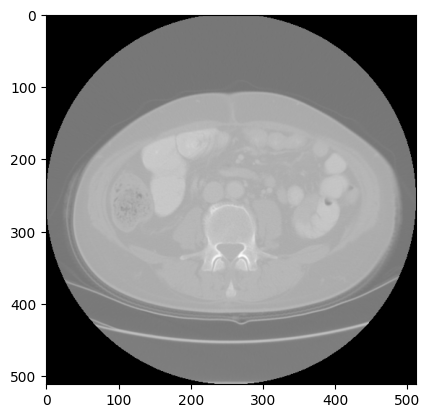

In [10]:
plt.imshow(dcm_example.pixel_array, cmap='gray')

In [14]:
dcm_example.elements

<bound method Dataset.elements of Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 206
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9590.100.1.2.419101075112260192217745601710305282295
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002,0013) Implementation Version Name         SH: '0.5'
(0002,0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'SECONDARY', 'AXIAL']
(0008,0012) Instance Creation Date              DA: '20220204'
(0008,0013) Instance Creation Time              TM: '150800'
(0008,0016) 